In [1]:
from data_generator import generate_moving_objects, visualize_3d_interactive
from spatial_hough import spatial_hough, calculate_optimal_delta, partition_points

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time
import itertools

In [2]:
def restore_line(xs, parameters, bounds):
    a, b = parameters
    points = a + np.outer(xs, b)

    for ax in range(3): # for each axis
        points = points[(points[:, ax] >= bounds[0][ax]) & (points[:, ax] <= bounds[1][ax])]    
        
    return points

In [3]:
def count_false_positives(measurements, detected_lines, threshold):
    false_positives, duplicates = 0, 0
    
    actual_lines = measurements[measurements["object_id"] != -1]["object_id"].unique()

    points_cloud = measurements[["x", "y", "time"]].to_numpy()
    delta = calculate_optimal_delta(points_cloud)

    points = {}
    for id in actual_lines:
        points[id] = measurements[measurements["object_id"] == id][["x", "y", "time"]].to_numpy()

    detections = {}
    for id in actual_lines:
        detections[id] = 0

    for i, line in enumerate(detected_lines):
        found_overlap = False

        for id in actual_lines:
            close_points, _ = partition_points(points[id], line, delta)

            overlap = close_points.shape[0] >= threshold
            found_overlap = found_overlap or overlap

            if overlap:
                if detections[id] > 0:
                    duplicates += 1
                
                detections[id] += 1
                break
        
        if not found_overlap:
            false_positives += 1

    non_detected = len([x for x in detections.values() if x == 0])
    return false_positives, duplicates, non_detected

In [4]:
def detect_lines(measurments, tesselation_steps=4, delta=None, threshold=10, adjust_lines=True):
    points_cloud = measurments[["x", "y", "time"]].to_numpy()
    lines = spatial_hough(
        points_cloud, 
        tesselation_steps=tesselation_steps, 
        delta=delta, 
        threshold=threshold, 
        adjust_lines=adjust_lines
    )
    print(count_false_positives(measurments, lines, threshold))

    bounds = np.min(points_cloud, axis=0), np.max(points_cloud, axis=0)
    xs = np.linspace(-1000, 1000, 10000)

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=points_cloud[:, 0],
        y=points_cloud[:, 1],
        z=points_cloud[:, 2],
        mode='markers',
        marker=dict(size=2),
        name="Points in"
    ))

    for i, parameters in enumerate(lines):
        line = restore_line(xs, parameters, bounds)

        fig.add_trace(go.Scatter3d(
            x=line[:, 0],
            y=line[:, 1],
            z=line[:, 2],
            mode='lines',
            line=dict(width=8),
            name=f"Line {i}"
        ))

    fig.show()

In [5]:
movement_data = generate_moving_objects(min_objects=5, max_objects=5, fake_detections_intensity=0)
visualize_3d_interactive(movement_data).show()

In [6]:
detect_lines(movement_data, threshold=30)

(0, 0, 0)


In [7]:
movement_data = generate_moving_objects(min_objects=5, max_objects=5, fake_detections_intensity=2)
detect_lines(movement_data, threshold=30)

(0, 0, 0)


In [8]:
movement_data = generate_moving_objects(min_objects=5, max_objects=5, fake_detections_intensity=10)
detect_lines(movement_data, threshold=30)

(0, 0, 0)


In [9]:
movement_data = generate_moving_objects(min_objects=5, max_objects=5, fake_detections_intensity=50)
detect_lines(movement_data, threshold=45)

(0, 0, 2)


In [10]:
frame_counts = [10, 25, 50, 100, 250]
noise_intensities = [0, 1, 2, 5, 10, 50, 100]

test_results = []
repeats = 10

for test_args in itertools.product(frame_counts, noise_intensities):
    num_points_per_object, noise_intensity = test_args
    threshold = int(num_points_per_object * 0.4 + noise_intensity * 0.4)

    for _ in range(repeats):
        measurements = generate_moving_objects(
            min_objects=15, max_objects=15,
            num_points_per_object=num_points_per_object, 
            fake_detections_intensity=noise_intensity
        )
        
        start = time.process_time_ns()

        points_cloud = measurements[["x", "y", "time"]].to_numpy()
        lines = spatial_hough(points_cloud, threshold=threshold)
        
        end = time.process_time_ns()
        duration = end - start

        false_positives, duplicates, non_detected = count_false_positives(measurements, lines, threshold)
        test_results.append([
            num_points_per_object, noise_intensity, duration, false_positives, duplicates, non_detected, len(lines)
        ])

test_results = pd.DataFrame(
    test_results, 
    columns=('Frames', 'Noise', 'Time unscaled', 'False positives', 'Duplicates', 'True negatives count', 'Total lines')
)

In [11]:
test_results

,Frames,Noise,Time unscaled,False positives,Duplicates,True negatives count,Total lines
0,10,0,156250000,0,0,0,15
1,10,0,156250000,0,0,3,12
2,10,0,203125000,0,0,0,15
3,10,0,125000000,0,0,6,9
4,10,0,156250000,0,0,0,15
...,...,...,...,...,...,...,...
345,250,100,8828125000,47,0,15,47
346,250,100,8843750000,47,0,13,49
347,250,100,7953125000,33,0,13,35
348,250,100,8437500000,43,0,12,46


In [12]:
time_scaled = test_results['Time unscaled'] / 1e+9
test_results['Time'] = time_scaled

false_positives_total = test_results['False positives'] + test_results['Duplicates']
test_results['False positives count'] = false_positives_total

test_results_avg = test_results.groupby(['Frames', 'Noise']).mean()
test_results_avg = test_results_avg[['Time', 'False positives count', 'True negatives count']]

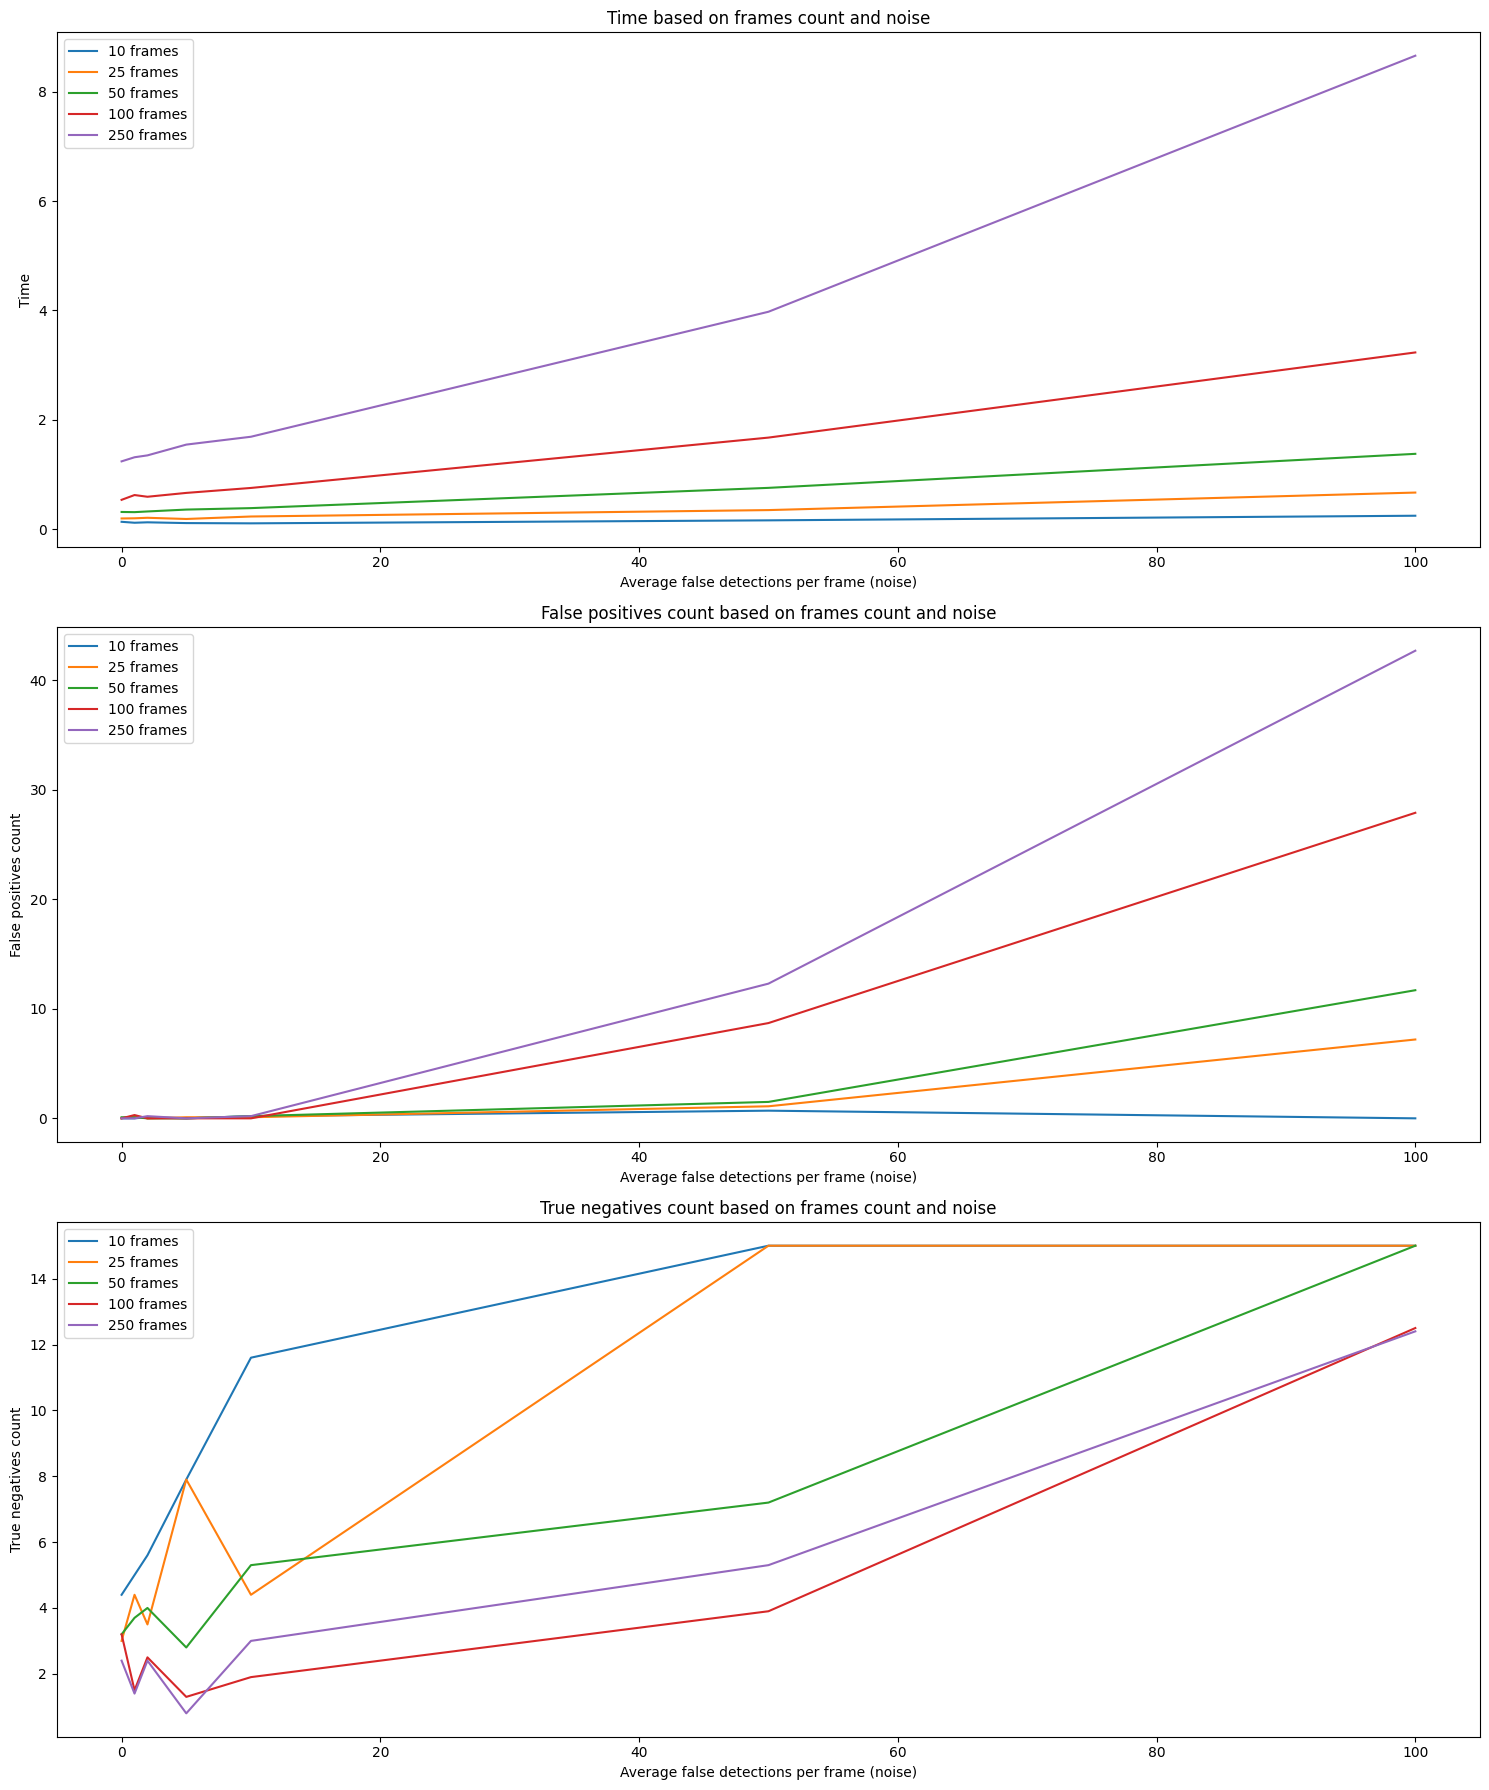

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(15, 18))

for i, metric in enumerate(['Time', 'False positives count', 'True negatives count']):
    ax[i].set_title(f'{metric} based on frames count and noise')
    ax[i].set_xlabel('Average false detections per frame (noise)')
    ax[i].set_ylabel(f'{metric}')

    for n in range(len(frame_counts)):
        ax[i].plot(
            test_results_avg.loc[frame_counts[n]][metric], 
            label=f'{frame_counts[n]} frames'
        )

    ax[i].legend()

fig.tight_layout()
plt.show()